In [463]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
from scipy.io import loadmat
import time
import threading
import heapq

In [464]:
class Hequation:
    def __init__(self,c, N):
        self.N = N
        self.d = N
        self.c = c
    #    self.a = a
        self.mu = np.array([np.arange(1, N + 1)]).T - 0.5
        self.M = 1 / (self.mu + self.mu.T)


        
    def grad(self, x):
        c = self.c
        tmp = 1 - c * self.mu * (self.M @ x) / 2 / self.N
        return x - 1 / tmp
    
    def hes_vec(self, x, v):
        c = self.c
        tmp = 1 - c * self.mu * (self.M @ x) / 2 / self.N
        hes_v = v -  c / 2 / self.N /tmp ** 2 * self.mu * (self.M @ v)
        return hes_v
    
    def hesT_vec(self, x, v):
        c=self.c
        tmp = 1 - c * self.mu * (self.M @ x) / 2 / self.N
        v_new = c/2/self.N/tmp**2 *self.mu*v
        hes_v = v-self.M@v_new
        return hes_v
    
    def hes(self, x):
        c = self.c
        tmp = 1 - c * self.mu * (self.M @ x) / 2 / self.N
      #  print(tmp.shape)
        return np.eye(self.N) -c / 2 / self.N / tmp ** 2 * self.mu * self.M

In [465]:
def GD(oracle, eta, x0, T):
    g=oracle.hesT_vec(x0,oracle.grad(x0))
    res=[np.linalg.norm(g)]
    time_t=[0]
    JV_list = [0]
    JV=0
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        x=x-eta*g
        g=oracle.hesT_vec(x,oracle.grad(x))
        JV=JV+1
        JV_list.append(JV)
        res.append(np.linalg.norm(g))
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list

In [466]:
def LM_1(oracle, M, x0, T):
    J=oracle.hes(x0)
    g=J.T@oracle.grad(x0)
    d=oracle.d
    Id = np.eye(d)
    res=[np.linalg.norm(g)]
    JV_list = [0]
    JV=0
    time_t=[0]
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        update = np.linalg.inv(J.T@J + M*np.linalg.norm(g)**0.5*Id)@g
        x=x-update
        J=oracle.hes(x)
        g=J.T@oracle.grad(x)
        JV = JV+d 
        JV_list.append(JV)
        res.append(np.linalg.norm(g))
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list


In [467]:
def GRLM(oracle, M, m, x0, T):
    F=oracle.grad(x0)
    g=oracle.hesT_vec(x0,F)
    d=oracle.d
    Id = np.eye(d)
    res=[np.linalg.norm(g)]
    JV_list = [0]
    JV=0
    time_t=[0]
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        if t%m == 0:
            J =oracle.hes(x)
            S,V=np.linalg.eigh(J.T@J)
            invV=np.linalg.inv(V)
            JV=JV+d
        inner_S= 1/(S+M*np.linalg.norm(g)**0.5)
        update = V@((np.diag(inner_S))@(invV@g))
        x=x-update
        F=oracle.grad(x)
        g=oracle.hesT_vec(x,F)
        JV=JV+1
        JV_list.append(JV)
        g_norm=np.linalg.norm(g)
        res.append(g_norm)
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list      
            

# Experiment 1. Comparison with Baselines under Different Dimension

# N=100

In [468]:
e=1e-10
oracle=Hequation(1-e,100)
d = oracle.N
x0=np.random.randn(d,1)

In [470]:
res_GD,time_GD,JV_GD=GD(oracle, 0.5, x0, 40000)

In [471]:
res_LM, time_LM,JV_LM=LM_1(oracle, 1, x0,3000)


In [472]:
res_GRLM, time_GRLM,JV_GRLM = GRLM(oracle, 1, 50, x0, 10000)

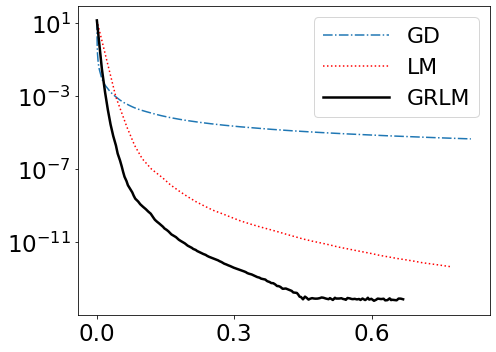

In [476]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD[:32000],res_GD[:32000],'-.',label='GD') 
plt.plot(time_LM[:2000:50],res_LM[:2000:50],':r',label='LM')
plt.plot(time_GRLM[:8000:50],res_GRLM[:8000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,0.3,0.6])
plt.yticks([1e-11,1e-7,1e-3,1e1])
plt.tight_layout()
plt.savefig('fig/N_100_time.png')
plt.savefig('fig/N_100_time.pdf',format='pdf')

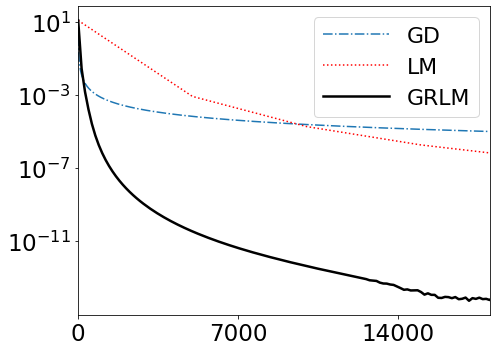

In [461]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD,res_GD,'-.',label='GD') 
plt.plot(JV_LM[:1000:50],res_LM[:1000:50],':r',label='LM')
plt.plot(JV_GRLM[:8000:50],res_GRLM[:8000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,7000,14000])
plt.xlim(0,18000)
plt.yticks([1e-11,1e-7,1e-3,1e1])
plt.tight_layout()
plt.savefig('fig/N_100_JV.png')
plt.savefig('fig/N_100_JV.pdf',format='pdf')

# N=200

In [477]:
e=1e-10
oracle=Hequation(1-e,200)
d = oracle.N
x0=np.random.randn(d,1)

In [478]:
res_GD,time_GD,JV_GD=GD(oracle, 0.5, x0, 40000)

In [479]:
res_LM, time_LM,JV_LM=LM_1(oracle, 1, x0,3000)


In [480]:
res_GRLM, time_GRLM,JV_GRLM = GRLM(oracle, 1, 50, x0, 10000)

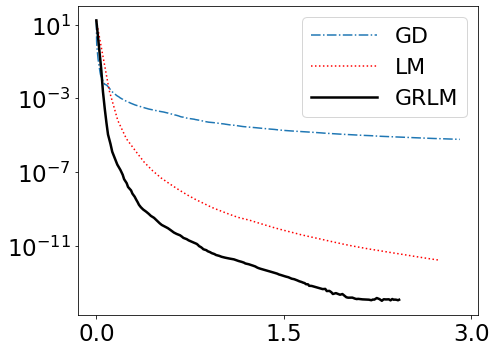

In [483]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD[:32000],res_GD[:32000],'-.',label='GD') 
plt.plot(time_LM[:2000:50],res_LM[:2000:50],':r',label='LM')
plt.plot(time_GRLM[:7000:50],res_GRLM[:7000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,1.5,3])
plt.yticks([1e-11,1e-7,1e-3,1e1])
plt.tight_layout()
plt.savefig('fig/N_200_time.png')
plt.savefig('fig/N_200_time.pdf',format='pdf')

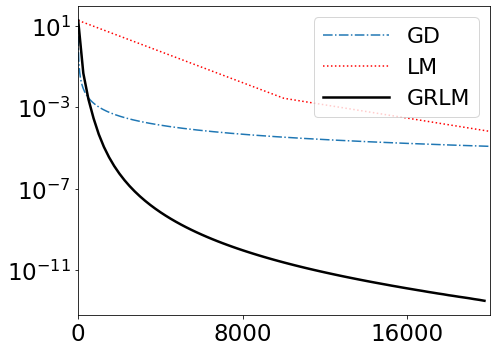

In [453]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD,res_GD,'-.',label='GD') 
plt.plot(JV_LM[:1000:50],res_LM[:1000:50],':r',label='LM')
plt.plot(JV_GRLM[:4000:50],res_GRLM[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,8000,16000])
plt.xlim(0,20000)
plt.yticks([1e-11,1e-7,1e-3,1e1])
plt.tight_layout()
plt.savefig('fig/N_200_JV.png')
plt.savefig('fig/N_200_JV.pdf',format='pdf')

## N=300

In [484]:
e=1e-10
oracle=Hequation(1-e,300)
d = oracle.N
x0=np.random.randn(d,1)

In [485]:
res_GD,time_GD,JV_GD=GD(oracle, 0.5, x0, 40000)

In [486]:
res_LM, time_LM,JV_LM=LM_1(oracle, 1, x0,3000)


In [487]:
res_GRLM, time_GRLM,JV_GRLM = GRLM(oracle, 1, 50, x0, 10000)

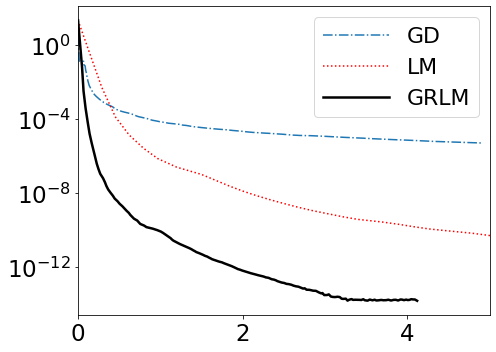

In [488]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD,res_GD,'-.',label='GD') 
plt.plot(time_LM[:2000:50],res_LM[:2000:50],':r',label='LM')
plt.plot(time_GRLM[:8000:50],res_GRLM[:8000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,2,4])
plt.xlim(0,5)
plt.yticks([1e-12,1e-8,1e-4,1])
plt.tight_layout()
plt.savefig('fig/N_300_time.png')
plt.savefig('fig/N_300_time.pdf',format='pdf')

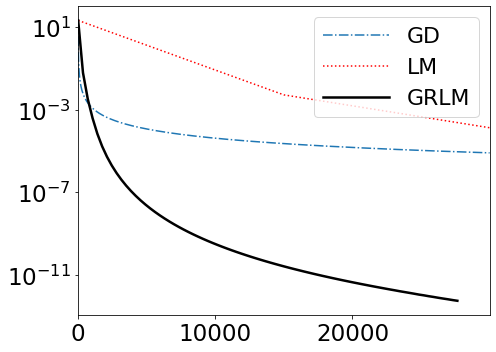

In [489]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD,res_GD,'-.',label='GD') 
plt.plot(JV_LM[:1000:50],res_LM[:1000:50],':r',label='LM')
plt.plot(JV_GRLM[:4000:50],res_GRLM[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,10000,20000])
plt.xlim(0,30000)
plt.yticks([1e-11,1e-7,1e-3,1e1])
plt.tight_layout()
plt.savefig('fig/N_300_JV.png')
plt.savefig('fig/N_300_JV.pdf',format='pdf')